# Monte Carlo Methods

Partly based on material of Elizaveta Semenova, Applied Machine Learning Days 2020, Bayesian Inference: embracing uncertainty.

## What are Monte Carlo Methods?

Monte Carlo Methods are a class of algorithms that infer quantities/parameter by using random number generators.

Monte Carlo Methods are probabilistic and not deterministic. This is, Monte Carlo Methods usually don't yield the same excat results when being repeating. Basically they are statistical methods, which estimate quantities - or parameters - rather than determining them.

Random numbers can be generated with different methods

 * Inversion Sampling
 * Rejection Sampling
 * Metropolis-Hastings Random Walk Sampling

In this Notebook, the following topics are covered

 * Monte Carlo Integration
 * Bayesian Parameter Inference with Metropolis-Hastings Algorithm
   * Coin Toss - Estimating Head's Probability
   * Normal Distribution
   * Linear Regression
   * Binomial Likelihood
   * Probabilistical Graphical Models
   * Probabilistic Networks
   * Bayes Networks
 


## Monte Carlo Integration
 
Monte Carlo Integration is one form of Numerical Integration. Numerical Integration calculates integrals $$ \int_{a}^{b}f(x)dx$$ of Riemann-integrable functions computationally instead of determining them analytically. This is useful because finding closed-form solutions for integrals is often difficult. Numerical Integration generally computes integrals by approximating the function, which is to be integrated, by a step function. Monte Carlo Integration, on the other hand, estimates this integral by estimating the fraction of random points that fall below $f(x)$. Monte Carlo Integration scales better to integration in high-dimensional spaces compared to Numerical Integration that is based on a step function aproach, which suffers heavily from the curse of dimensionality.


### Example

Determine the integral $\int_0^1 e^x dx$.

Analytically, this can be calculated by $e^1 - e^0 = e - 1$ 

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as mc
import scipy.stats as stats

In [62]:
# Calculate Integral Analytically
np.exp(1) - np.exp(0)

1.718281828459045

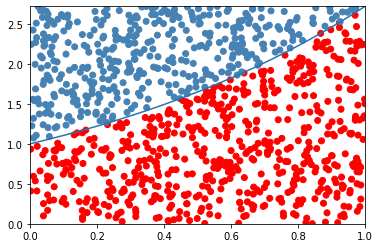

In [63]:
# Monte Carlo Integration - Visualization

no_points = 1000

x = np.linspace(0, 1, no_points)
plt.plot(x, np.exp(x));
pts = np.random.uniform(0,1,(no_points, 2))
pts[:, 1] *= np.e

cols = ['red'] * no_points
for i in range(no_points):
    if pts[i,1] > np.exp(pts[i,0]):     # acceptance / rejection step
        cols[i] = 'steelblue'
    
plt.scatter(pts[:, 0], pts[:, 1], c = cols)
plt.xlim([0,1])
plt.ylim([0, np.e]);

In [64]:
# Monte Carlo Integration - Estimation

for n in 10**np.array([1,2,3,4,5,6,7]):
    pts = np.random.uniform(0, 1, (n, 2))
    pts[:, 1] *= np.e
    count = np.sum(pts[:, 1] < np.exp(pts[:, 0]))
    volume = np.e * 1 # volume of region
    sol = (volume * count)/n    
    print(f'{n} {sol}')

10 1.6309690970754271
100 1.7940660067829697
1000 1.742418652042248
10000 1.7299145556313364
100000 1.7184434063152392
1000000 1.717826356340179
10000000 1.7175009780053123


## Monte Carlo Estimation in Bayes Inference

In this second use case we use Monte Carlo Methos to do staticial inference. In statistical inference we have a non-deterministic data generating process that produces some data. We assume that a probability distribution underlies and describes this data generating process. The probability distribution is parametrized by $\theta \in \Theta$. In statistical inference we infer $\theta$.

In Bayes inference, in contrast to maximum likelihood inference, we assume a probability distribution over $\theta \in \Theta$. Given some data $x = x_{i=1}^n$ from the data generating process, we try to find the probability distribution $p(\theta | x)$ as well as $\underset{\theta \in \Theta}{argmax}p(\theta | x)$. The rule of Bayes allows us to calculate $p(\theta | x)$ through

$$ p(\theta | x) = \frac{p(x | \theta)p(\theta)}{p(x)}$$

Metropolis-Hastings Random Walk algorithms are a class of algorithms that are able to approximate any probability density functions (pdf) $p$ through random sampling given a function $f$ that is proportional to $p$. This is $p = cf$ for $c \in ℝ$. We can use those sampling algorithms to sample $p(\theta | x)$ through

$$ p(\theta | x) \propto p(x | \theta)p(\theta) $$

This is very useful since we don't need to calculate the data term $p(x)$ to estimate $p(\theta | x)$. If we have to calclate the marginal probability density function $p(x)$ we usually have to integrate $\theta$ out, which is usually quite hard to do.

$$ p(x) = \int_{\theta}p(x | \theta) p(\theta)d\theta $$

Sampling algorithms like the Metropolis-Hastings Random Walk algorithm can't be used for parameter estimation in the maximum likelihood setting. This is, because the likelihood function is not a probability density function. Thus we can't estimate it with the Metropolis-Hastings algortihm, which approximates pdfs. However, other Monte Carlo methods can be use for parameter estimation in maximum likelihood scanerios. Infering parameters with Monte Carlo methods im maximum likelihood settings can be necessary because of a likelihood function, which is not differentiable or complicated to differentiate.

## Coin Tossing Example

In this example we are tossing a coin, which can come up either heads or tails. Let's assume we tossed the coin $n = 10$ times and it came up heads $h = 6$ times. From this data we want to estimate the probability $\theta = p_{head} = p$. Since we want to use a Metropolis-Hastings sampling algortihm to approximate the distribution $p(\theta | x) we have to use Bayes inference. Metropolis-Hastings algorithms can't be used to estimate parameters from likelihood functions.

Applying Bayes inference, we infer $p$ by the Maximum Aposteriori (MAP) Estimator. Instead of using the symbol $p$ we use the symbol $\theta$ to refer to the probability of head coming up in our coin toss example. We do this to avoid confusion with the probability density function (pdf) which is also refered to by $p$.

$$ p(\theta; a, b) = \theta^{\alpha - 1}(1-\theta)^{\beta -1} $$

for $a, b > 0$ and $\theta \in [0, 1]$. 


We see that, depending on the choice of a and b, the probability density function of the beta prior for our unknown parameter $\theta$ looks quite different.

We are given now a

* beta prior with parameters $a$ and $b$
* binomial likelihood
* observed data $n$ of total coin flips and $h$ number of heads

This yields a beta posterior as the distribution of our unknown parameter $\theta$ with parameters $a+h$ and $b+n-h$. Let's plot the pdf of this distribution with a couple of values for $a, b, n$ and $h$.

### Bayes Estimation - Metropolis-Hastings Random Walk

In [80]:
n = 100
h = 60
a = 10
b = 10

likelihood = stats.binom
prior = stats.beta(a, b)
sigma = 0.3

def target(likelihood, prior, n: int, h: int, theta: float) -> float:
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(n, theta).pmf(h)*prior.pdf(theta)

naccept = 0
theta = 0.1
niters = 2000

samples = np.zeros(niters+1)
samples[0] = theta

for i in range(niters):
    theta_p = theta + stats.norm(0, sigma).rvs()
    rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta

Portion of accepted steps = 0.176


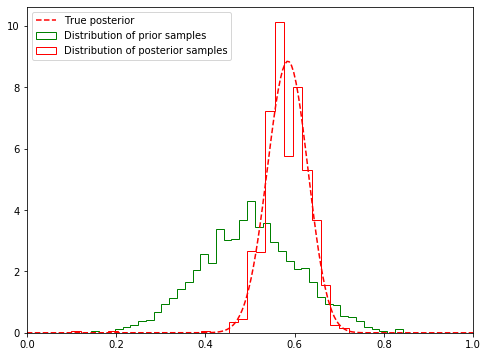

In [98]:
print("Portion of accepted steps = " + str(naccept/niters))

posterior_true = stats.beta(a+h, b+n-h)

thetas = np.linspace(0, 1, 200)
plt.figure(figsize=(8, 6))
plt.hist(prior.rvs(len(samples)), 40, histtype='step', color='green', density=True, label='Distribution of prior samples');
plt.hist(samples, 30, histtype='step', color='red', density=True, label='Distribution of posterior samples');
plt.plot(thetas, posterior_true.pdf(thetas), c='red', linestyle='--', alpha=1, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='upper left');

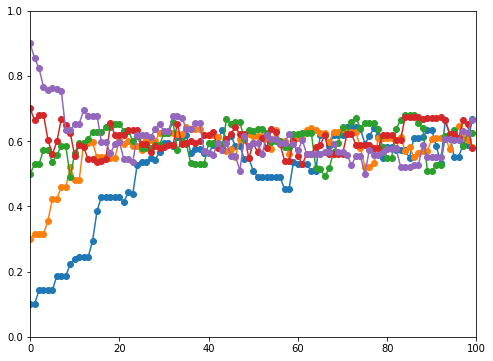

In [99]:
# ## Convergence diagnostics


def mh_coin(niters, n, h, theta, likelihood, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs()
        rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
        
    return samples



n = 100
h = 61
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
niters = 100



chains = [mh_coin(niters, n, h, theta, likelihood, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]



plt.figure(figsize=(8, 6))

for chain in chains:
    plt.plot(chain, '-o')
    
plt.xlim([0, niters])
plt.ylim([0, 1]);